In [1]:
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline 

In this notebook, I explore the sample fire dipatch data provided to HACK OR. My first step is to look at length of times between response steps for a given incident (ie time between dispatch to on-scene).

In [37]:
# connect to postgres db on vb

try:
    conn = psycopg2.connect(database='vagrant', user='eruser', password = 'emergency', host='localhost', port='5432')
    print("Opened database successfully")
    
except psycopg2.Error as e:
    print("I am unable to connect to the database")
    print(e)
    print(e.pgcode)
    print(e.pgerror)
    print(traceback.format_exc())

Opened database successfully


In [10]:

def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        #pprint(D)
        #conn.close()
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)
    
   

In [11]:
# look at 10K rows of inctimes table first
QUERY1='''SELECT inctimes."Incident_ID", inctimes."TimeDesc_ID", inctimes."RealTime"
FROM fire_dispatch.inctimes
ORDER BY inctimes."Incident_ID", inctimes."TimeDesc_ID"
LIMIT 10000;
'''

In [12]:
df1 = pquery(QUERY1)

SQL QUERY = SELECT inctimes."Incident_ID", inctimes."TimeDesc_ID", inctimes."RealTime"
FROM fire_dispatch.inctimes
ORDER BY inctimes."Incident_ID", inctimes."TimeDesc_ID"
LIMIT 10000;



In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
Incident_ID    10000 non-null int64
TimeDesc_ID    10000 non-null int64
RealTime       10000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 234.5 KB


In [14]:
df1.head(15)

,Incident_ID,TimeDesc_ID,RealTime
0,1102989,1,2014-09-22 08:33:03
1,1102989,2,2014-09-22 08:34:16
2,1102989,3,2014-09-22 08:34:33
3,1102989,3,2014-09-22 08:34:33
4,1102989,3,2015-01-19 10:29:50
5,1102989,4,2014-09-22 08:35:41
6,1102989,4,2014-09-22 08:35:41
7,1102989,5,2014-09-22 08:42:43
8,1102989,5,2014-09-22 08:42:43
9,1102989,7,2014-09-22 08:56:03


In [15]:
'''For incident 1102989, there appear to be wierd values, such as the NaT values which correspond to the "Trial" cells 
in the db and then timestamps in 2015 which don't make sense. Let's audit the data for duplicates. 
This code shows all rows that have a duplicate pair of incident_id,timedesc_id'
'''

df1.duplicated(['Incident_ID','TimeDesc_ID'],keep = False) 

0       False
1       False
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9       False
10       True
11       True
12      False
13      False
14      False
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23      False
24      False
25      False
26       True
27       True
28      False
29      False
        ...  
9970     True
9971     True
9972     True
9973     True
9974     True
9975     True
9976     True
9977    False
9978     True
9979     True
9980     True
9981    False
9982    False
9983     True
9984     True
9985     True
9986     True
9987     True
9988     True
9989    False
9990    False
9991    False
9992    False
9993    False
9994     True
9995     True
9996     True
9997     True
9998     True
9999    False
dtype: bool

In [17]:
# print only rows where a duplicate incident_id/timedesc_id pair exists
df1[df1.duplicated(['Incident_ID','TimeDesc_ID'],keep = False)]

,Incident_ID,TimeDesc_ID,RealTime
2,1102989,3,2014-09-22 08:34:33
3,1102989,3,2014-09-22 08:34:33
4,1102989,3,2015-01-19 10:29:50
5,1102989,4,2014-09-22 08:35:41
6,1102989,4,2014-09-22 08:35:41
7,1102989,5,2014-09-22 08:42:43
8,1102989,5,2014-09-22 08:42:43
10,1102989,12,2014-09-22 08:56:03
11,1102989,12,2015-01-19 10:29:55
15,1102990,3,2014-09-22 08:51:13


Looking at the duplicates above, it seems that the first row is more likely to be the "correct" one. Some events have duplicate timestamps for TimeDesc_ID that are not even in the same year as the first entry, which seems unlikely. For purposes if this analysis, I will treat the first instance of the TimeDesc_ID as correct and ignore the other duplicates. **However, this merits further discussion with the data people at PF&R and more investigation should be made into why duplicates occur and what they might mean.**

In [18]:
# this code does that
df1[df1.duplicated(['Incident_ID','TimeDesc_ID'],keep = 'first') == False]

,Incident_ID,TimeDesc_ID,RealTime
0,1102989,1,2014-09-22 08:33:03
1,1102989,2,2014-09-22 08:34:16
2,1102989,3,2014-09-22 08:34:33
5,1102989,4,2014-09-22 08:35:41
7,1102989,5,2014-09-22 08:42:43
9,1102989,7,2014-09-22 08:56:03
10,1102989,12,2014-09-22 08:56:03
12,1102990,0,2014-09-22 08:49:54
13,1102990,1,2014-09-22 08:50:08
14,1102990,2,2014-09-22 08:50:56


In [57]:
#test some pandas timestamp math
df1['RealTime'][5]-df1['RealTime'][3]
df1['RealTime'][5]

Timestamp('2014-09-22 08:35:41')

In [24]:
df1_nd = df1[df1.duplicated(['Incident_ID','TimeDesc_ID'],keep = 'first') == False]

In [83]:
# here is function that calculates time deltas

def time_delta(dataframe,TimeDesc_ID1,TimeDesc_ID2):
    '''caluclates the time delta between two different TimeDesc_IDs for all groups'''
    count = 0
    delta_dict = {}
    for name, group in dataframe.groupby('Incident_ID'):
        #print(name)
        #print(group)
        df_t = group.set_index('TimeDesc_ID') # reset the group df to index on TimeDesc_ID
        #print(df_t)
        #print(df_t.loc[3,'RealTime'])
        #print(df_t.loc[5,'RealTime'])
        #print(df_t.loc[5,'RealTime']-df_t.loc[3,'RealTime'])
        try:
            delta =  df_t.loc[TimeDesc_ID2,'RealTime']-df_t.loc[TimeDesc_ID1,'RealTime']
            delta_dict[name] = delta
        except KeyError:
            delta = None
            delta_dict[name] = delta
        #count += 1
        #if count == 1:
            #break
    return delta_dict
     

In [93]:
#print(time_delta(df1_nd, 3, 5))
time_delta_df = pd.Series(time_delta(df1_nd, 3, 5), name='TimeDelta_5-3')
time_delta_df.index.name = 'Incident_ID'
time_delta_df.head(100)

Incident_ID
1102989            00:08:10
1102990            00:04:51
1102991            00:04:30
1102992            00:09:01
1102993            00:04:28
1102994            00:05:14
1102995            00:03:10
1102996            00:04:07
1102997            00:04:37
1102998            00:03:38
1102999            00:06:35
1103000            00:06:23
1103001   -1 days +23:52:56
1103002            00:02:03
1103003            00:05:26
1103004            00:07:12
1103005            00:02:59
1103006            00:10:12
1103007            00:05:02
1103008            00:08:10
1103009            00:06:19
1103010            00:04:35
1103011            00:04:24
1103012            00:04:40
1103013            00:04:13
1103014            00:11:40
1103015                 NaT
1103016            00:02:37
1103017            00:05:08
1103018            00:03:18
                 ...       
1103059            00:01:51
1103060            00:03:03
1103061            00:04:17
1103062            00:00:00
1103063 

In [94]:
time_delta_df.describe()

count                       610
mean     0 days 00:05:29.465573
std      0 days 00:06:56.365097
min           -1 days +23:18:35
25%             0 days 00:03:45
50%             0 days 00:04:52
75%      0 days 00:06:16.750000
max             0 days 02:30:48
Name: TimeDelta_5-3, dtype: object

In [99]:
'''pandas cannot plot histgram by just using: time_delta_df.plot()
So we need to do some timedelta conversion to a more easily plotted numerical type.
My approach was to convert the deltas to decimal expression of minutes. This link was helpful:
http://www.datasciencebytes.com/bytes/2015/05/16/pandas-timedelta-histograms-unit-conversion-and-overflow-danger/
'''
print(time_delta_df.dropna() / pd.Timedelta(minutes=1)) # note that I dropped missing values from the time_delta_df

Incident_ID
1102989     8.166667
1102990     4.850000
1102991     4.500000
1102992     9.016667
1102993     4.466667
1102994     5.233333
1102995     3.166667
1102996     4.116667
1102997     4.616667
1102998     3.633333
1102999     6.583333
1103000     6.383333
1103001    -7.066667
1103002     2.050000
1103003     5.433333
1103004     7.200000
1103005     2.983333
1103006    10.200000
1103007     5.033333
1103008     8.166667
1103009     6.316667
1103010     4.583333
1103011     4.400000
1103012     4.666667
1103013     4.216667
1103014    11.666667
1103016     2.616667
1103017     5.133333
1103018     3.300000
1103019     7.700000
             ...    
1103607     8.000000
1103608     4.683333
1103609    11.150000
1103610     4.483333
1103611     4.116667
1103612     4.000000
1103613     5.916667
1103614    12.783333
1103615     2.350000
1103616     7.533333
1103617     5.183333
1103618     1.000000
1103619     2.716667
1103621     3.966667
1103622     3.766667
1103623     4.200000
1

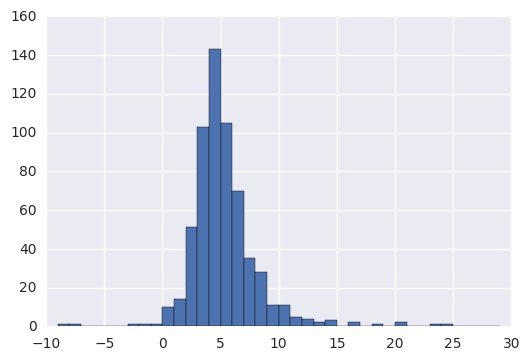

In [114]:
(time_delta_df.dropna() / pd.Timedelta(minutes=1)).hist(bins = range(-10,30,1))

From the histogram and summary statistics above, we can see that the mean response time between dispatch and on-scene is around 5.5 minutes. There are some negative values which are impossible, so those should be removed. IMO, this response time seems quite good, athough I'm not sure what "industry standards" are. **_1/10/17 Next, I can rebuild a summary dataframe with additional time deltas, not just between events 5 and 3. Not all timedelta pairs can be calculated for each incident id due to missing data, however._**

In [115]:
# show descriptions of dispatch events
QUERY2='''SELECT * FROM fire_dispatch.timedesc;
  '''

In [116]:
incident_types = pquery(QUERY2)

SQL QUERY = SELECT * FROM fire_dispatch.timedesc;
  


In [117]:
incident_types

,TimeDesc_ID,Description,ID_911
0,0,Received ...,None
1,1,Initiated ...,None
2,2,Entered ...,ENTRY:
3,3,Dispatched ...,DISP
4,4,Enroute ...,ENROUT
5,5,On Scene ...,ONSCNE
6,6,Fire Under Control ...,None
7,7,Close ...,CLOSE
8,8,With Patient ...,None
9,9,Depart Scene ...,None


In [118]:
conn.close()